## Instalaçao das bibliotecas a serem utilizadas

In [ ]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install spacy
!python -m spacy download en_core_web_sm
!{sys.executable} -m pip install -U scikit-learn
!{sys.executable} -m pip install matplotlib


In [28]:
import pandas as pd


Carrega a base de dados

In [29]:
df = pd.read_csv("classificacaoCOncluida.csv")
print(df.shape)
df.head(10)


(3807, 12)


,Unnamed: 0,Element_id,Collaboration_id,Element_type,Name,Category,Vitor,Diego,wasThereConsensus,HasOnePositiveClassification,Element_supertype,classificationLabel
0,1,Id_ace65391-08a8-41d7-ac2c-4dbb714db3ff,Id_a0e6717a-4e36-476c-a988-ed009c847883,serviceTask,Approve contract additive,PP,1,1,True,False,Tasks,Negative
1,2,Id_ace65391-08a8-41d7-ac2c-4dbb714db3ff,Id_a0e6717a-4e36-476c-a988-ed009c847883,serviceTask,Approve contract additive,STT,5,5,True,True,Tasks,Positive
2,3,Id_ace65391-08a8-41d7-ac2c-4dbb714db3ff,Id_a0e6717a-4e36-476c-a988-ed009c847883,serviceTask,Approve contract additive,PDI,5,5,True,True,Tasks,Positive
3,4,Id_1522756e-bc2a-41f2-aca1-519d5bdc285e,Id_a605b7ad-e3c9-4bd6-960b-3e13e3130b03,endEvent,Breach of contract,PP,1,4,False,True,Events,Inconclusive
4,5,Id_1522756e-bc2a-41f2-aca1-519d5bdc285e,Id_a605b7ad-e3c9-4bd6-960b-3e13e3130b03,endEvent,Breach of contract,STT,1,1,True,False,Events,Negative
5,6,Id_1522756e-bc2a-41f2-aca1-519d5bdc285e,Id_a605b7ad-e3c9-4bd6-960b-3e13e3130b03,endEvent,Breach of contract,PDI,5,5,True,True,Events,Positive
6,7,Id_df1fdcb6-a5d9-4f7c-8f0e-645e8887f8a7,Id_b3f958bb-3a4c-4376-8e2b-9674d6a050d1,exclusiveGateway,Content type,PP,1,1,True,False,Gateway,Negative
7,8,Id_df1fdcb6-a5d9-4f7c-8f0e-645e8887f8a7,Id_b3f958bb-3a4c-4376-8e2b-9674d6a050d1,exclusiveGateway,Content type,STT,1,1,True,False,Gateway,Negative
8,9,Id_df1fdcb6-a5d9-4f7c-8f0e-645e8887f8a7,Id_b3f958bb-3a4c-4376-8e2b-9674d6a050d1,exclusiveGateway,Content type,PDI,1,1,True,False,Gateway,Negative
9,10,Id_dca9376d-6ca2-414a-9fe8-821c076c239b,Id_8370a4a2-361c-4103-9dd0-465bf6958936,exclusiveGateway,Type of material,PP,1,1,True,False,Gateway,Negative


# Separando os dados que vamos utilizar por enquanto

Separando apenas as colunas que serao utilizadas pelo algoritimo

In [30]:
df= df[['Name','Element_supertype','Category','classificationLabel']]
df.head(5)

,Name,Element_supertype,Category,classificationLabel
0,Approve contract additive,Tasks,PP,Negative
1,Approve contract additive,Tasks,STT,Positive
2,Approve contract additive,Tasks,PDI,Positive
3,Breach of contract,Events,PP,Inconclusive
4,Breach of contract,Events,STT,Negative


In [31]:
df['classificationLabel'].value_counts()

Negative        1571
Inconclusive    1278
Positive         958
Name: classificationLabel, dtype: int64

Filtrando apenas pelo supertipo 'Task'

In [32]:
df_filtred = df[df['Element_supertype'] == 'Tasks'].copy()
print(df_filtred.Element_supertype.value_counts())
df_filtred.head()

Tasks    2523
Name: Element_supertype, dtype: int64


,Name,Element_supertype,Category,classificationLabel
0,Approve contract additive,Tasks,PP,Negative
1,Approve contract additive,Tasks,STT,Positive
2,Approve contract additive,Tasks,PDI,Positive
12,Prepare communication briefing,Tasks,PP,Positive
13,Prepare communication briefing,Tasks,STT,Negative


Retirando as inconclusivas e convertendo Postivas para 1 e negativas para 0

In [33]:
df_filtred.drop(df_filtred[(df_filtred['classificationLabel'] == 'Inconclusive')].index, inplace=True)
df_filtred['Category'].value_counts()
df_filtred['bclassification'] = df_filtred['classificationLabel'].apply(lambda x: 1 if x=='Positive' else 0) 
df = df_filtred

Lower all text

In [34]:
df['Name'] = df['Name'].str.lower()
df.head()

,Name,Element_supertype,Category,classificationLabel,bclassification
0,approve contract additive,Tasks,PP,Negative,0
1,approve contract additive,Tasks,STT,Positive,1
2,approve contract additive,Tasks,PDI,Positive,1
12,prepare communication briefing,Tasks,PP,Positive,1
13,prepare communication briefing,Tasks,STT,Negative,0


# Pre Process
    Declaraçao das funcoes de retirada de stop words e lematizacao

In [35]:
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm")



def preprocess_stop_lemma(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)

def preprocess_stop(text):
    # remove stop words

    doc = nlp(text)
    filtered_tokens = []
    global totaltokens
    global stopCount

    for token in doc:
        if token.is_stop:
            stopCount+=1
            continue
        if token.is_punct:
            continue
        totaltokens+=1
        filtered_tokens.append(token.text)
    return " ".join(filtered_tokens)
def preprocess_lemma(text):
    # lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    global totalWords
    global noChangesCount
    for token in doc:
        if token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
        totalWords+=1
        if (str(token.lemma_)==str(token)):
            noChangesCount+=1
    return " ".join(filtered_tokens)

## Cria dataframes para cada uma das classes
As funcos de pre processamento sao chamadas, sendo adicionandas colunas com os textos pre processados
Tambem é feita uma contagem de quantas palavras foram retiradas como stop words e quantas foram editadas pela lematizacao

## STT

In [36]:
totalWords=0
noChangesCount=0
totaltokens=0
stopCount=0
df_stt = df[df['Category'].str.endswith('STT')].copy()
df_stt['Names_clean_sl'] = df_stt['Name'].apply(preprocess_stop_lemma)
df_stt['Names_clean_s'] = df_stt['Name'].apply(preprocess_stop)
print('stopCount =',stopCount,'total tokens = ',totaltokens)
df_stt['Names_clean_l'] = df_stt['Name'].apply(preprocess_lemma)
print('NoChange = ',noChangesCount,'total words =',totalWords)
print(df_stt['classificationLabel'].value_counts())
df_stt.head()

stopCount = 239 total tokens =  1527
NoChange =  1556 total words = 1766
Negative    398
Positive    124
Name: classificationLabel, dtype: int64


,Name,Element_supertype,Category,classificationLabel,bclassification,Names_clean_sl,Names_clean_s,Names_clean_l
1,approve contract additive,Tasks,STT,Positive,1,approve contract additive,approve contract additive,approve contract additive
13,prepare communication briefing,Tasks,STT,Negative,0,prepare communication briefing,prepare communication briefing,prepare communication briefing
22,notify rejection,Tasks,STT,Positive,1,notify rejection,notify rejection,notify rejection
25,check costs,Tasks,STT,Negative,0,check cost,check costs,check cost
31,use credit,Tasks,STT,Negative,0,use credit,use credit,use credit


## PP

In [37]:
totalWords=0
noChangesCount=0
totaltokens=0
stopCount=0
df_pp = df[df['Category'].str.endswith('PP')].copy()
df_pp['Names_clean_sl'] = df_pp['Name'].apply(preprocess_stop_lemma)
df_pp['Names_clean_s'] = df_pp['Name'].apply(preprocess_stop)
print('stopCount =',stopCount,'total tokens = ',totaltokens)
df_pp['Names_clean_l'] = df_pp['Name'].apply(preprocess_lemma)
print('NoChange = ',noChangesCount,'total words =',totalWords)
print(df_pp['classificationLabel'].value_counts())
df_pp.head()

stopCount = 200 total tokens =  1153
NoChange =  1209 total words = 1353
Negative    196
Positive    190
Name: classificationLabel, dtype: int64


,Name,Element_supertype,Category,classificationLabel,bclassification,Names_clean_sl,Names_clean_s,Names_clean_l
0,approve contract additive,Tasks,PP,Negative,0,approve contract additive,approve contract additive,approve contract additive
12,prepare communication briefing,Tasks,PP,Positive,1,prepare communication briefing,prepare communication briefing,prepare communication briefing
18,negotiate debt payment,Tasks,PP,Positive,1,negotiate debt payment,negotiate debt payment,negotiate debt payment
30,use credit,Tasks,PP,Negative,0,use credit,use credit,use credit
39,reject enrollment,Tasks,PP,Positive,1,reject enrollment,reject enrollment,reject enrollment


## PDI

In [38]:
totalWords=0
noChangesCount=0
totaltokens=0
stopCount=0
df_pdi = df[df['Category'].str.endswith('PDI')].copy()
df_pdi['Names_clean_sl'] = df_pdi['Name'].apply(preprocess_stop_lemma)
df_pdi['Names_clean_s'] = df_pdi['Name'].apply(preprocess_stop)
print('stopCount =',stopCount,'total tokens = ',totaltokens)
df_pdi['Names_clean_l'] = df_pdi['Name'].apply(preprocess_lemma)
print('NoChange = ',noChangesCount,'total words =',totalWords)
print(df_pdi['classificationLabel'].value_counts())
df_pdi.head()

stopCount = 251 total tokens =  1727
NoChange =  1751 total words = 1978
Positive    408
Negative    177
Name: classificationLabel, dtype: int64


,Name,Element_supertype,Category,classificationLabel,bclassification,Names_clean_sl,Names_clean_s,Names_clean_l
2,approve contract additive,Tasks,PDI,Positive,1,approve contract additive,approve contract additive,approve contract additive
14,prepare communication briefing,Tasks,PDI,Negative,0,prepare communication briefing,prepare communication briefing,prepare communication briefing
23,notify rejection,Tasks,PDI,Positive,1,notify rejection,notify rejection,notify rejection
35,approve purchase order change,Tasks,PDI,Positive,1,approve purchase order change,approve purchase order change,approve purchase order change
44,adjust document,Tasks,PDI,Positive,1,adjust document,adjust document,adjust document


# Balanceando os datasets

## Oversampling
    para cada classe balanceamos os dados duplicando aleatoriamente elementos classificados na classe com menos elementos

In [39]:
def balance(auxdf,count,dominant):
    df_overclass = auxdf[auxdf['classificationLabel']==dominant].sample(count, replace=True, random_state=2022)
    df_False = auxdf[auxdf['classificationLabel']!=dominant]

    df_balanced = pd.concat([df_overclass, df_False],axis=0)

    return df_balanced.sample(frac=1, random_state=2022).reset_index(drop=True)
    

System, tools, and technologies (STT)

In [40]:
x = df_stt['classificationLabel'].value_counts()
y = x.index
if x[0]!=x[1]:
    df_stt = balance(df_stt,max(x),y[1])
print(df_stt['classificationLabel'].value_counts())
df_stt.head()

Positive    398
Negative    398
Name: classificationLabel, dtype: int64


,Name,Element_supertype,Category,classificationLabel,bclassification,Names_clean_sl,Names_clean_s,Names_clean_l
0,perform data verification,Tasks,STT,Positive,1,perform datum verification,perform data verification,perform datum verification
1,receive payment,Tasks,STT,Negative,0,receive payment,receive payment,receive payment
2,close service request,Tasks,STT,Positive,1,close service request,close service request,close service request
3,project registered in the uf system,Tasks,STT,Positive,1,project register uf system,project registered uf system,project register in the uf system
4,receive data request for cnpq scholarship,Tasks,STT,Positive,1,receive datum request cnpq scholarship,receive data request cnpq scholarship,receive datum request for cnpq scholarship


PDI

In [42]:
x = df_pdi['classificationLabel'].value_counts()
y = x.index

if x[0]!=x[1]:
    df_pdi = balance(df_pdi,max(x),y[1])
print(df_pdi['classificationLabel'].value_counts())
df_pdi.head()

Negative    408
Positive    408
Name: classificationLabel, dtype: int64


,Name,Element_supertype,Category,classificationLabel,bclassification,Names_clean_sl,Names_clean_s,Names_clean_l
0,login,Tasks,PDI,Negative,0,login,login,login
1,prepare material,Tasks,PDI,Negative,0,prepare material,prepare material,prepare material
2,designate specialist,Tasks,PDI,Negative,0,designate specialist,designate specialist,designate specialist
3,issue contract,Tasks,PDI,Positive,1,issue contract,issue contract,issue contract
4,receive invoice from supplier,Tasks,PDI,Positive,1,receive invoice supplier,receive invoice supplier,receive invoice from supplier


PP

In [43]:
x = df_pp['classificationLabel'].value_counts()
y = x.index

if x[0]!=x[1]:
    df_pp = balance(df_pp,max(x),y[1])
print(df_pp['classificationLabel'].value_counts())

df_pp.head()

Positive    196
Negative    196
Name: classificationLabel, dtype: int64


,Name,Element_supertype,Category,classificationLabel,bclassification,Names_clean_sl,Names_clean_s,Names_clean_l
0,receive material,Tasks,PP,Positive,1,receive material,receive material,receive material
1,request medical coats for students,Tasks,PP,Positive,1,request medical coat student,request medical coats students,request medical coat for student
2,forward danfe to dispatcher,Tasks,PP,Positive,1,forward danfe dispatcher,forward danfe dispatcher,forward danfe to dispatcher
3,get client password confirmation,Tasks,PP,Positive,1,client password confirmation,client password confirmation,get client password confirmation
4,change invoice to receive,Tasks,PP,Negative,0,change invoice receive,change invoice receive,change invoice to receive


# Building the Model


In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt


In [45]:
## ecolher entre 'roc_auc' e 'accuracy'
scoretipe = 'accuracy'

Bag of words

In [46]:
def bow(dfaux,colname):
    cl1 = SVC()
    cl2 = MultinomialNB()
    cl3 = ComplementNB()
    cl4 = RandomForestClassifier(random_state=2022)
    
    
    clf = Pipeline([('preprocessor',CountVectorizer()),('classifier',cl1)])

    params1 = {'preprocessor__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)], 'classifier': [cl1]}

    params2 = {'preprocessor__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)], 'classifier': [cl2]}

    params3 = {'preprocessor__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)], 'classifier': [cl3]}

    params4 = {'preprocessor__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)], 'classifier': [cl4]}

    params = [params1,params2,params3,params4]
    # n_jobs = Number of jobs to run in parallel -1 means using all processors. Can be changed to the desired number of processors
    grid = GridSearchCV(clf, params, n_jobs=-1, cv=5,scoring=scoretipe)
    grid.fit(dfaux[colname],dfaux['bclassification'])


    return pd.DataFrame(grid.cv_results_)[['param_classifier','param_preprocessor__ngram_range','mean_test_score']]



TFID

In [47]:
def tfidf(dfaux,colname):
    cl1 = SVC()
    cl2 = MultinomialNB()
    cl3 = ComplementNB()
    cl4 = RandomForestClassifier(random_state=2022)
    
    
    clf = Pipeline([('preprocessor',TfidfVectorizer()),('classifier',cl1)])

    params1 = {'preprocessor__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)], 'classifier': [cl1]}

    params2 = {'preprocessor__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)], 'classifier': [cl2]}

    params3 = {'preprocessor__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)], 'classifier': [cl3]}

    params4 = {'preprocessor__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)], 'classifier': [cl4]}

    params = [params1,params2,params3,params4]
    
    # n_jobs = Number of jobs to run in parallel -1 means using all processors. Can be changed to the desired number of processors
    grid = GridSearchCV(clf, params, n_jobs=-1, cv=5, scoring=scoretipe)
    grid.fit(dfaux[colname],dfaux['bclassification'])
    
    return  pd.DataFrame(grid.cv_results_)[['param_classifier','param_preprocessor__ngram_range','mean_test_score']]


## Executa os testes (avaliando conforme escolhido) para todas as combinacoes de tecnicas e registra em arquivos separados

In [48]:
df_completo = pd.DataFrame()
classe = {'PDI':df_pdi, 'PP':df_pp, 'STT':df_stt}
for x in ['Name', 'Names_clean_sl', 'Names_clean_s', 'Names_clean_l']:
    for y in classe:
        df_aux = bow(classe[y],x)
        df_aux['class']= y
        df_aux['algorithm']= 'BOW'
        df_aux['textPreprocess']= x

        df_completo = pd.concat([df_completo,df_aux],axis=0)

        df_aux = tfidf(classe[y],x)
        df_aux['class']= y
        df_aux['algorithm']= 'TF-IDF'
        df_aux['textPreprocess']= x

        df_completo = pd.concat([df_completo,df_aux],axis=0)
        print(y,x,'completo')

df_completo.to_csv('completo.csv',index=False)


PDI Name completo
PP Name completo
STT Name completo
PDI Names_clean_sl completo
PP Names_clean_sl completo
STT Names_clean_sl completo
PDI Names_clean_s completo
PP Names_clean_s completo
STT Names_clean_s completo
PDI Names_clean_l completo
PP Names_clean_l completo
STT Names_clean_l completo


In [49]:
df_completo

,param_classifier,param_preprocessor__ngram_range,mean_test_score,class,algorithm,textPreprocess
0,SVC(),"(1, 1)",0.899461,PDI,BOW,Name
1,SVC(),"(1, 2)",0.852895,PDI,BOW,Name
2,SVC(),"(2, 2)",0.696065,PDI,BOW,Name
3,SVC(),"(1, 3)",0.839421,PDI,BOW,Name
4,SVC(),"(2, 3)",0.618869,PDI,BOW,Name
...,...,...,...,...,...,...
19,RandomForestClassifier(random_state=2022),"(1, 2)",0.934662,STT,TF-IDF,Names_clean_l
20,RandomForestClassifier(random_state=2022),"(2, 2)",0.885605,STT,TF-IDF,Names_clean_l
21,RandomForestClassifier(random_state=2022),"(1, 3)",0.939686,STT,TF-IDF,Names_clean_l
22,RandomForestClassifier(random_state=2022),"(2, 3)",0.886863,STT,TF-IDF,Names_clean_l


## Executa novo treino com os melhores casos de n-gramas em cada combinaçao classe - algoritimo para gerar grafico

In [50]:
def split(names_column,df_class):
    X_train, X_test, y_train, y_test = train_test_split(
        df_class[names_column],
        df_class['bclassification'],
        test_size=0.2, # 20% samples will go to test dataset
        stratify=df_class['bclassification'],
        random_state=1873211
        )
    return X_train, X_test, y_train, y_test

In [51]:
def tfidf2(X_train, X_test, y_train, y_test,classe,best):

    models = [MultinomialNB(),ComplementNB(),RandomForestClassifier(),SVC()]
    names = ['MultinomialNB','ComplementNB','RFC','SVC']
    for name,mod in enumerate(models):
        v = TfidfVectorizer(ngram_range=best[str(mod)])
        X_train_count = v.fit_transform(X_train.values)
        model = mod
        model.fit(X_train_count,y_train)


        X_test_count = v.transform( X_test)
        svc_disp = RocCurveDisplay.from_estimator(model, X_test_count, y_test, ax=ax,name=classe + names[name] +str(best[str(mod)]))


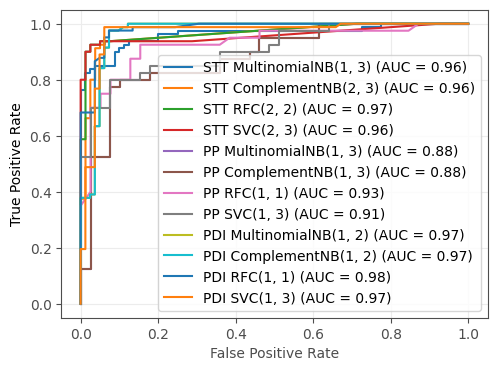

In [52]:
df_stt.name='STT '
df_pp.name='PP '
df_pdi.name='PDI '
dfs = [df_stt,df_pp,df_pdi]

#selecionar o numero de ngramas que apresentaram melhor desempenho para cada algoritimo em cada classe
bestpdi= {'MultinomialNB()':(1,2),'ComplementNB()':(1,2),'RandomForestClassifier()':(1,1),'SVC()':(1,3)}
bestpp = {'MultinomialNB()':(1,3),'ComplementNB()':(1,3),'RandomForestClassifier()':(1,1),'SVC()':(1,3)}
beststt = {'MultinomialNB()':(1,3),'ComplementNB()':(2,3),'RandomForestClassifier()':(2,2),'SVC()':(2,3)}
bests = [beststt,bestpp,bestpdi]
plt.figure(figsize=[5.5,4],frameon=False)

ax = plt.gca()
ax.set_facecolor("white")



for x,df_ in enumerate(dfs):
    X_train, X_test, y_train, y_test = split('Names_clean_sl',df_)
    tfidf2(X_train, X_test, y_train, y_test,df_.name,bests[x])
plt.grid(color='#ececec')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(facecolor="white")
ax.spines['bottom'].set_color('#4d4d4d')
ax.spines['top'].set_color('#4d4d4d')
ax.xaxis.label.set_color('#4d4d4d')
ax.tick_params(axis='x', colors='#4d4d4d')

ax.spines['left'].set_color('#4d4d4d')
ax.spines['right'].set_color('#4d4d4d')
ax.xaxis.label.set_color('#4d4d4d')
ax.tick_params(axis='y', colors='#4d4d4d')

plt.savefig('line_plot.pdf')